In [1]:
!pip install -q split-folders
import splitfolders
import os
import shutil
import random
import csv
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
from pathlib import Path
import pandas as pd
from PIL import Image
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.applications import ResNet50, InceptionV3
from tensorflow import keras as K
from tensorflow.keras.applications.xception import Xception
from keras import Model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras import regularizers
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Functions**

In [ ]:
root_dir = '/content/drive/MyDrive/Multiclass_Yearwise/original_data'

train_years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
test_years = [2020, 2021, 2022]

train_file_list = []
train_label_list= []
test_file_list = []
test_label_list = []

for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        file_path = os.path.join(subdir, file)
        label = os.path.split(subdir)[1] 
        year = os.path.split(os.path.split(subdir)[0])[1]
        if int(year) in train_years:
            train_file_list.append(file_path)
            train_label_list.append(label)
        elif int(year) in test_years:
            test_file_list.append(file_path)
            test_label_list.append(label)

if not os.path.exists('/content/drive/MyDrive/Multiclass_Yearwise/train'):
    os.makedirs('/content/drive/MyDrive/Multiclass_Yearwise/train')
if not os.path.exists('/content/drive/MyDrive/Multiclass_Yearwise/test'):
    os.makedirs('/content/drive/MyDrive/Multiclass_Yearwise/test')

for file_path, label in zip(train_file_list, train_label_list):
    label_dir = os.path.join('/content/drive/MyDrive/Multiclass_Yearwise/train', label)
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
    shutil.copy(file_path, label_dir)

for file_path, label in zip(test_file_list, test_label_list):
    label_dir = os.path.join('/content/drive/MyDrive/Multiclass_Yearwise/test', label)
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
    shutil.copy(file_path, label_dir)

In [ ]:
# Set the path to the main folder and the destination folder
destination_folder = '/content/drive/MyDrive/Multiclass_Yearwise'

# Split the main folder into train and validation sets in a ratio
splitfolders.ratio('/content/drive/MyDrive/Multiclass_Yearwise/data', output=destination_folder, seed=12, ratio=(0.7, 0.3), group_prefix=None, move=False)
print("Files are splitted in the ratio 0.7, 0.3")

Copying files: 1445 files [00:17, 80.53 files/s]

Files are splitted in the ratio 0.7, 0.3


# **Data Visualization**

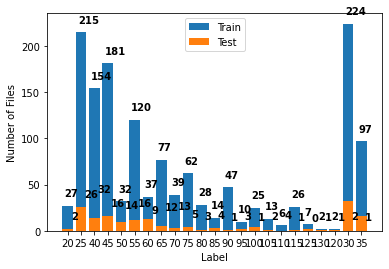

In [ ]:
train_dir = '/content/drive/MyDrive/Multiclass_Yearwise/train'
#val_dir = '/content/drive/MyDrive/Multiclass_Yearwise/val'
test_dir = '/content/drive/MyDrive/Multiclass_Yearwise/test'

train_labels = []
train_counts = []
val_labels = []
val_counts = []
test_labels = []
test_counts = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    if os.path.isdir(label_dir):
        train_labels.append(label)
        train_counts.append(len(os.listdir(label_dir)))

for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)
    if os.path.isdir(label_dir):
        test_labels.append(label)
        test_counts.append(len(os.listdir(label_dir)))

fig, ax = plt.subplots()
ax.bar(train_labels, train_counts, label = 'Train')
ax.bar(test_labels, test_counts, label = 'Test')
ax.set_xlabel('Label')
ax.set_ylabel('Number of Files')

for i, v in enumerate(train_counts):
    ax.text(i - 0.25, v + 10, str(v), fontweight = 'bold')
for i, v in enumerate(test_counts):
    ax.text(i + 0.25, v + 10, str(v), fontweight = 'bold')  
    
ax.legend()
plt.show()

In [ ]:
total_count = sum(train_counts)
for i in range(len(train_labels)):
    percentage = train_counts[i] / total_count * 100
    print(train_labels[i], ": {:.2f}%".format(percentage))

20 : 1.87%
25 : 14.88%
40 : 10.66%
45 : 12.53%
50 : 2.21%
55 : 8.30%
60 : 2.56%
65 : 5.33%
70 : 2.70%
75 : 4.29%
80 : 1.94%
85 : 0.97%
90 : 3.25%
95 : 0.69%
100 : 1.73%
105 : 0.90%
110 : 0.42%
115 : 1.80%
125 : 0.48%
130 : 0.14%
120 : 0.14%
30 : 15.50%
35 : 6.71%


In [ ]:
total_count = sum(test_counts)
for i in range(len(test_labels)):
    percentage = test_counts[i] / total_count * 100
    print(test_labels[i], ": {:.2f}%".format(percentage))

20 : 1.18%
25 : 15.38%
30 : 18.93%
35 : 9.47%
40 : 8.28%
45 : 9.47%
50 : 5.33%
55 : 7.10%
60 : 7.69%
65 : 2.96%
70 : 1.78%
75 : 2.37%
80 : 0.59%
85 : 1.78%
90 : 0.59%
95 : 1.18%
100 : 2.37%
105 : 0.59%
110 : 0.00%
115 : 0.59%
120 : 0.59%
125 : 1.18%
130 : 0.59%


In [ ]:
ratios = []

for i in range(len(train_counts)):
  ratio = (train_counts[i] / (train_counts[i] + test_counts[i])) * 100
  ratios.append(ratio)

for i in range(len(ratios)):
  print(f'{ratios[i]:.0f}:{100-ratios[i]:.0f}')

93:7
89:11
83:17
92:8
70:30
88:12
80:20
87:13
75:25
93:7
90:10
78:22
98:2
77:23
96:4
87:13
60:40
96:4
100:0
67:33
67:33
99:1
99:1


In [ ]:
def create_class_counts_dict(counts, labels):
    # Initialize a dictionary to store the class counts
    class_counts = {}

    # Iterate over the counts and labels, and add the count for each class to the dictionary
    for count, label in zip(counts, labels):
        if label in class_counts:
            class_counts[label] += count
        else:
            class_counts[label] = count

    return class_counts

# Create a dictionary that maps class labels to the number of occurrences of each class in the dataset
class_counts = create_class_counts_dict(train_counts, train_labels)

# Calculate the total number of images in the dataset
total_images = sum(class_counts.values())

# Iterate over the class counts dictionary and calculate the percentage of each class
for label, count in class_counts.items():
    percentage = count / total_images * 100
    print(f'Class: {label}, Count: {count}, Percentage: {percentage:.2f}%')

train_images = glob.glob('/content/drive/MyDrive/Multiclass_Yearwise/train/*/*.jpg')
test_images = glob.glob('/content/drive/MyDrive/Multiclass_Yearwise/test/*/*.jpg')

total_images = len(train_images) + len(test_images)
total_num_train_images = len(train_images)
#total_num_val_images = len(val_images)
total_num_test_images = len(test_images)

print('Total num of training images:', total_num_train_images)
print('Total num of test images:', total_num_test_images)
print('Total number of images:', total_images)

files = os.listdir(train_dir)
num_classes = 0
for item in files:
  if os.path.isdir(os.path.join(train_dir, item)):
    num_classes += 1
print(f'Number of classes in {train_dir}: {num_classes}')

Class: 20, Count: 27, Percentage: 1.87%
Class: 25, Count: 215, Percentage: 14.88%
Class: 40, Count: 154, Percentage: 10.66%
Class: 45, Count: 181, Percentage: 12.53%
Class: 50, Count: 32, Percentage: 2.21%
Class: 55, Count: 120, Percentage: 8.30%
Class: 60, Count: 37, Percentage: 2.56%
Class: 65, Count: 77, Percentage: 5.33%
Class: 70, Count: 39, Percentage: 2.70%
Class: 75, Count: 62, Percentage: 4.29%
Class: 80, Count: 28, Percentage: 1.94%
Class: 85, Count: 14, Percentage: 0.97%
Class: 90, Count: 47, Percentage: 3.25%
Class: 95, Count: 10, Percentage: 0.69%
Class: 100, Count: 25, Percentage: 1.73%
Class: 105, Count: 13, Percentage: 0.90%
Class: 110, Count: 6, Percentage: 0.42%
Class: 115, Count: 26, Percentage: 1.80%
Class: 125, Count: 7, Percentage: 0.48%
Class: 130, Count: 2, Percentage: 0.14%
Class: 120, Count: 2, Percentage: 0.14%
Class: 30, Count: 224, Percentage: 15.50%
Class: 35, Count: 97, Percentage: 6.71%
Total num of training images: 1445
Total num of test images: 169
Tot

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, fill_mode='constant', cval=0)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(310, 310), batch_size=2, class_mode='categorical', shuffle=True)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(310, 310), batch_size=1, class_mode='categorical', shuffle=False)

# Get the class names from the generator
train_class_names = list(train_generator.class_indices.keys())
print("Training dataset class names",train_class_names)

Found 1445 images belonging to 23 classes.
Found 169 images belonging to 23 classes.
Training dataset class names ['100', '105', '110', '115', '120', '125', '130', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', '95']


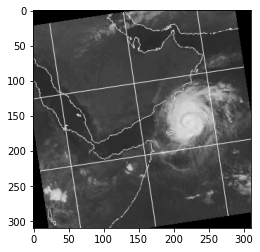

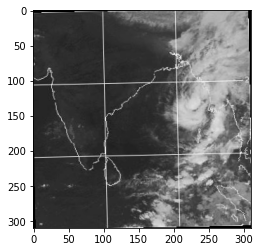

In [ ]:
# Get a batch of images from the train_generator
images, labels = next(train_generator)

# Plot the images
for i in range(len(images)):
    plt.figure()
    plt.imshow(images[i])

# Show the plot
plt.show()

# **Classification Model**

In [ ]:
# Load the Proposed Model
proposed_model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(32, (3,3), input_shape=(310,310,3), activation='relu', padding="same"),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(64, (3,3), input_shape=(310,310,3), activation='relu', padding="same"),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding="same"),
tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding="same"),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(0.3),

tf.keras.layers.Dense(units=512, activation='relu'),
tf.keras.layers.Dropout(0.4),

tf.keras.layers.Dense(5, activation = 'softmax', kernel_regularizer = regularizers.l2(0.01))
])

In [ ]:
total_count = sum(train_counts)
train_counts = np.array(train_counts)
alpha = (1 - train_counts / total_count)

from tensorflow import keras as K
# Define the Focal Loss function
def focal_loss(gamma=2., alpha=alpha):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.math.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) - tf.math.reduce_mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))
    return focal_loss_fixed

proposed_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = focal_loss(gamma=2., alpha = alpha), metrics = ['accuracy'])

In [ ]:
proposed_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/multiclass_proposed_best_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

In [ ]:
history = proposed_model.fit(train_generator, epochs=50, validation_data=test_generator, callbacks=[checkpoint, lr_scheduler, early_stopping], verbose = 1)

Epoch 1/50
723/723 [==============================] - 43s 59ms/step - loss: 1.6990 - accuracy: 0.2249 - val_loss: 1.6706 - val_accuracy: 0.2308 - lr: 1.0000e-04
Epoch 2/50
723/723 [==============================] - 45s 62ms/step - loss: 1.6016 - accuracy: 0.2976 - val_loss: 1.6385 - val_accuracy: 0.2781 - lr: 1.0000e-04
Epoch 3/50
723/723 [==============================] - 43s 59ms/step - loss: 1.5066 - accuracy: 0.3661 - val_loss: 1.6306 - val_accuracy: 0.2840 - lr: 1.0000e-04
Epoch 4/50
723/723 [==============================] - 42s 58ms/step - loss: 1.4417 - accuracy: 0.3903 - val_loss: 1.6513 - val_accuracy: 0.2130 - lr: 1.0000e-04
Epoch 5/50
723/723 [==============================] - 41s 57ms/step - loss: 1.4020 - accuracy: 0.4277 - val_loss: 1.6482 - val_accuracy: 0.2308 - lr: 1.0000e-04
Epoch 6/50
723/723 [==============================] - 41s 57ms/step - loss: 1.3443 - accuracy: 0.4450 - val_loss: 1.7000 - val_accuracy: 0.2308 - lr: 1.0000e-04
Epoch 7/50
723/723 [==============

In [ ]:
# Load the model from the file
model = load_model('/content/drive/MyDrive/multiclass_proposed_best_weights.h5')

# Extract the validation accuracy from the history object
test_acc = history.history['val_accuracy']
print(max(test_acc))

In [ ]:
# Plot the validation accuracy over the course of training
plt.plot(val_acc)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
val_generator.reset()
val_predictions = proposed_model.predict(val_generator)

label_map = dict((v, k) for k, v in train_generator.class_indices.items())
print(label_map)

actualLables_val = [label_map[k] for k in val_generator.classes]
print("Length of actual validation labels:", len(actualLables_val))

# Generate predictions for the validation data
val_predictions = proposed_model.predict(val_generator, verbose = 1)

# Convert the predictions to a one-hot encoded format
val_predictions = np.argmax(val_predictions, axis=1)
predictedLables_val = [label_map[k] for k in val_predictions]

val_loss, val_accuracy = proposed_model.evaluate(val_generator, batch_size = 1)
print(f"Validation Loss:     {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
confusion_matrix = sk_confusion_matrix(actualLables_val, predictedLables_val)

print(confusion_matrix)

437/437 [==============================] - 3s 6ms/step
{0: 'CS', 1: 'D', 2: 'DD', 3: 'SevereCS', 4: 'VSCS'}
Length of actual validation labels: 437
437/437 [==============================] - 3s 7ms/step - loss: 1.1019 - accuracy: 0.6796
Validation Loss:     1.1018601655960083
Validation Accuracy: 0.6796338558197021
[[86  1  9 10  5]
 [12 43 12  3  3]
 [20  8 66  0  3]
 [21  1  2 32 15]
 [ 6  1  4  4 70]]


In [ ]:
test_generator.reset()
test_predictions = proposed_model.predict(test_generator)

label_map = dict((v, k) for k, v in test_generator.class_indices.items())
print(label_map)

actualLables_test = [label_map[k] for k in test_generator.classes]
print("Length of actual test labels:", len(actualLables_test))

# Generate predictions for the validation data
test_predictions = proposed_model.predict(test_generator, verbose = 1)

# Convert the predictions to a one-hot encoded format
test_predictions = np.argmax(test_predictions, axis=1)
predictedLables_test = [label_map[k] for k in test_predictions]

# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
confusion_matrix = sk_confusion_matrix(actualLables_test, predictedLables_test)

print(confusion_matrix)

test_loss, test_accuracy = proposed_model.evaluate(test_generator, batch_size = 1)
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

169/169 [==============================] - 139s 824ms/step
{0: 'CS', 1: 'D', 2: 'DD', 3: 'SevereCS', 4: 'VSCS'}
Length of actual test labels: 169
169/169 [==============================] - 1s 6ms/step
[[13  2  4 16  4]
 [ 4  5  4  8  7]
 [18  0  6 17  7]
 [ 9  8  3 10  0]
 [ 6  3  0  9  6]]
169/169 [==============================] - 1s 7ms/step - loss: 4.1985 - accuracy: 0.2367
Test Loss:     4.198478698730469
Test Accuracy: 0.23668639361858368


In [ ]:
#model = load_model('/content/drive/MyDrive/multiclass_proposed_best_weights.h5', custom_objects = {'focal_loss_fixed': focal_loss})

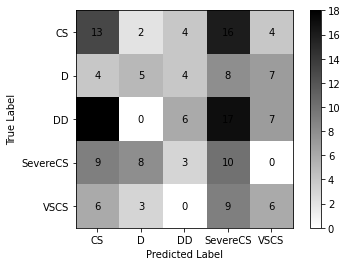

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(actualLables_test, predictedLables_test)

plt.imshow(conf_mat, cmap='binary')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(np.unique(actualLables_test))), np.unique(actualLables_test))
plt.yticks(np.arange(len(np.unique(actualLables_test))), np.unique(actualLables_test))
plt.colorbar()

for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(j, i, conf_mat[i, j], ha='center', va='center', color='black')

plt.show()

In [ ]:
print("Actual \t Predicted")
for i in range(len(actualLables_val)):
    print(actualLables_val[i] + '\t ' + predictedLables_val[i])

# **Regression Model**

In [2]:
image_dir = Path("/content/drive/MyDrive/Multiclass_Yearwise/train")
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name = 'Filepath').astype(str)
intensity = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name = 'Intensity').astype(int)

images = pd.concat([filepaths, intensity], axis = 1).sample(frac = 1.0, random_state = 1).reset_index(drop = True)
train_df = images.sample(len(images), random_state = 1).reset_index(drop = True)

image_dir = Path("/content/drive/MyDrive/Multiclass_Yearwise/test")
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name = 'Filepath').astype(str)
intensity = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name = 'Intensity').astype(int)

images = pd.concat([filepaths, intensity], axis = 1).sample(frac = 1.0, random_state = 1).reset_index(drop = True)
val_df = images.sample(len(images), random_state = 1).reset_index(drop = True)

train_labels = train_df.iloc[:, -1].values
val_labels = val_df.iloc[:, -1].values

In [3]:
train_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, fill_mode='constant', cval=0)
val_generator = ImageDataGenerator(rescale = 1./255)

train_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='Filepath', y_col='Intensity', target_size=(310, 310), class_mode='raw',
                                                   batch_size=2, shuffle=True)

val_images = val_generator.flow_from_dataframe(dataframe=val_df, x_col='Filepath', y_col='Intensity', class_mode='raw', target_size=(310, 310), 
                                                 batch_size=1, shuffle=False)

Found 1445 validated image filenames.
Found 169 validated image filenames.


**Proposed**

In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(32, (3, 3), input_shape = (310, 310, 3), activation = 'relu', name = 'Conv1'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', name = 'Conv2'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', name = 'Conv3'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', name = 'Conv4'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(units = 512, activation = 'relu'),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Dense(1, activation = 'linear')
])

# Compile model with a regression loss function and an Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

checkpoint = ModelCheckpoint('/content/drive/MyDrive/regression_proposed_best_weights.h5', monitor='val_loss',  save_best_only=True,  mode='max')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

# Train model with the fit() method
history = model.fit(train_images, epochs=40, validation_data=val_images, callbacks=[checkpoint, lr_scheduler, early_stopping], verbose=1)

Epoch 1/40
723/723 [==============================] - 46s 61ms/step - loss: 688.2777 - val_loss: 540.4752 - lr: 0.0010
Epoch 2/40
723/723 [==============================] - 43s 59ms/step - loss: 572.8591 - val_loss: 555.4572 - lr: 0.0010
Epoch 3/40
723/723 [==============================] - 43s 59ms/step - loss: 532.8594 - val_loss: 557.4967 - lr: 0.0010
Epoch 4/40
723/723 [==============================] - 44s 60ms/step - loss: 510.7157 - val_loss: 576.5064 - lr: 0.0010
Epoch 5/40
723/723 [==============================] - 46s 63ms/step - loss: 499.0475 - val_loss: 605.6872 - lr: 0.0010
Epoch 6/40
723/723 [==============================] - 40s 55ms/step - loss: 486.7122 - val_loss: 519.2700 - lr: 0.0010
Epoch 7/40
723/723 [==============================] - 39s 54ms/step - loss: 485.8286 - val_loss: 600.4916 - lr: 0.0010
Epoch 8/40
723/723 [==============================] - 42s 58ms/step - loss: 471.1816 - val_loss: 629.8637 - lr: 0.0010
Epoch 9/40
723/723 [============================

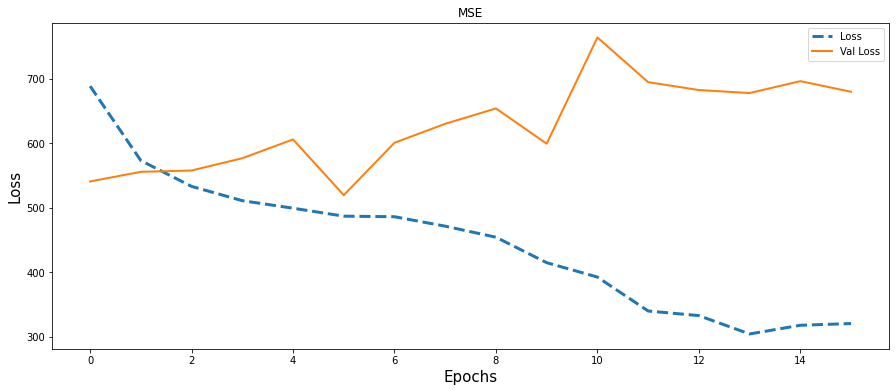

In [ ]:
# Load the model from the file
model = load_model('/content/drive/MyDrive/regression_proposed_best_weights.h5')

plt.figure(figsize = (15, 6))
plt.plot(history.history['loss'], lw = 3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('MSE')
plt.legend();

In [ ]:
val_images.reset()
predicted_intensity = np.squeeze(model.predict(val_images))
#predicted_intensity = np.round(predicted_intensity/5, 0)*5
true_intensity = val_images.labels

rmse = np.sqrt(model.evaluate(val_images, verbose = 0))
print("Validation RMSE: {:.5f}".format(rmse))

print('Standard deviation in predicted validation intensities:', np.std(predicted_intensity))
mse = mean_squared_error(true_intensity, predicted_intensity)
print('Validation MSE: {:.2f}'.format(mse))
mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Validation MAE: {:.2f}'.format(mae))

169/169 [==============================] - 1s 7ms/step
Validation RMSE: 27.63565
Standard deviation in predicted validation intensities: 8.682195
Validation MSE: 763.73
Validation MAE: 19.30


**VGG16**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg16_model = VGG16(pooling = 'avg', weights = 'imagenet', include_top = False, input_shape = (310, 310, 3))

for layers in vgg16_model.layers:
    layers.trainable = False

last_output = vgg16_model.layers[-1].output

vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(1, activation = 'linear')(vgg_x)

vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(optimizer = 'adam', loss = 'mse')

# Create a checkpoint to save best weights
checkpoint = ModelCheckpoint('/content/drive/MyDrive/regression_vgg16_best_weights.h5', monitor='val_loss', save_best_only=True, mode='min')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

history = vgg16_final_model.fit(train_images, validation_data=val_images, epochs=60, callbacks=[checkpoint, early_stopping, lr_scheduler], verbose=1)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/60
723/723 [==============================] - 62s 81ms/step - loss: 697.9393 - val_loss: 515.9854 - lr: 0.0010
Epoch 2/60
723/723 [==============================] - 53s 73ms/step - loss: 548.3981 - val_loss: 500.5098 - lr: 0.0010
Epoch 3/60
723/723 [==============================] - 57s 79ms/step - loss: 540.1362 - val_loss: 494.0950 - lr: 0.0010
Epoch 4/60
723/723 [==============================] - 55s 75ms/step - loss: 533.7514 - val_loss: 486.4030 - lr: 0.0010
Epoch 5/60
723/723 [==============================] - 51s 71ms/step - loss: 527.7954 - val_loss: 507.7878 - lr: 0.0010
Epoch 6/60
723/723 [==============================] - 47s 65ms/step - loss: 519.6581 - val_loss: 476.5761 - lr: 0.0010
Epoch 7/60
723/723 [==============================] - 52s 72ms/step - loss: 511.4818 - val_loss: 468.2727 - lr: 0.0010
Epoch 8/60
723/723 [==============================] - 50s 70ms/step - loss: 505.3167 - val_loss: 464.5

In [ ]:
model = load_model('/content/drive/MyDrive/regression_vgg16_best_weights.h5')

plt.figure(figsize = (15, 6))
plt.plot(history.history['loss'], lw = 3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('MSE')
plt.legend();

In [ ]:
val_images.reset()
predicted_intensity = np.squeeze(model.predict(val_images))
#predicted_intensity = np.round(predicted_intensity/5, 0)*5
true_intensity = val_images.labels

rmse = np.sqrt(model.evaluate(val_images, verbose = 0))
print("Validation RMSE: {:.5f}".format(rmse))

print('Standard deviation in predicted validation intensities:', np.std(predicted_intensity))
mse = mean_squared_error(true_intensity, predicted_intensity)
print('Validation MSE: {:.2f}'.format(mse))
mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Validation MAE: {:.2f}'.format(mae))

Resnet

In [ ]:
ResNet50_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (310, 310, 3), classes=20)
for layers in ResNet50_model.layers:
    layers.trainable = True

resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256, activation='relu')(resnet50_x)
resnet50_x = Dense(1, activation = 'linear')(resnet50_x)
resnet50_x_final_model = Model(inputs = ResNet50_model.input, outputs = resnet50_x)

resnet50_x_final_model.compile(optimizer = 'adam', loss = 'mse')

# Create a checkpoint to save best weights
checkpoint = ModelCheckpoint('/content/drive/MyDrive/regression_resnet_best_weights.h5', monitor='val_loss', save_best_only=True, mode='min')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

history = resnet50_x_final_model.fit(train_images, validation_data=val_images, epochs=60, callbacks=[checkpoint, early_stopping, lr_scheduler], verbose=1)

In [ ]:
model = load_model('/content/drive/MyDrive/regression_resnet_best_weights.h5')

plt.figure(figsize = (15, 6))
plt.plot(history.history['loss'], lw = 3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('MSE')
plt.legend();

In [ ]:
val_images.reset()
predicted_intensity = np.squeeze(model.predict(val_images))
#predicted_intensity = np.round(predicted_intensity/5, 0)*5
true_intensity = val_images.labels

rmse = np.sqrt(model.evaluate(val_images, verbose = 0))
print("Validation RMSE: {:.5f}".format(rmse))

print('Standard deviation in predicted validation intensities:', np.std(predicted_intensity))
mse = mean_squared_error(true_intensity, predicted_intensity)
print('Validation MSE: {:.2f}'.format(mse))
mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Validation MAE: {:.2f}'.format(mae))

**Xception**

In [4]:
from tensorflow.keras.applications.xception import Xception
xception_model = Xception(include_top = False, weights = "imagenet", input_shape = (310, 310, 3))
x = Flatten()(xception_model.output)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(1, activation = 'linear')(x)

xception_final_model = Model(inputs = xception_model.input, outputs = x)

xception_final_model.compile(optimizer = 'adam', loss = 'mse')

# Create a checkpoint to save best weights
checkpoint = ModelCheckpoint('/content/drive/MyDrive/regression_xception_best_weights.h5', monitor='val_loss', save_best_only=True, mode='min')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

history = xception_final_model.fit(train_images, validation_data = val_images, epochs = 30, callbacks =[checkpoint, early_stopping, lr_scheduler], verbose = 1)

83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/30
723/723 [==============================] - 415s 487ms/step - loss: 777.0780 - val_loss: 2727.0325 - lr: 0.0010
Epoch 2/30
723/723 [==============================] - 90s 124ms/step - loss: 585.7763 - val_loss: 1762.0726 - lr: 0.0010
Epoch 3/30
723/723 [==============================] - 94s 129ms/step - loss: 438.0639 - val_loss: 450.6673 - lr: 0.0010
Epoch 4/30
723/723 [==============================] - 76s 105ms/step - loss: 465.9076 - val_loss: 894.3411 - lr: 0.0010
Epoch 5/30
723/723 [==============================] - 75s 104ms/step - loss: 463.7799 - val_loss: 6254.8188 - lr: 0.0010
Epoch 6/30
723/723 [==============================] - 78s 108ms/step - loss: 368.3503 - val_loss: 589.4521 - lr: 0.0010
Epoch 7/30
723/723 [==============================] - 86s 119ms/step - loss: 318.7709 - val_loss: 397.6770 - lr: 0.0010
Epoch 8/30
723/723 [==============================] - 75s 103ms/step - loss: 309.4883 - val

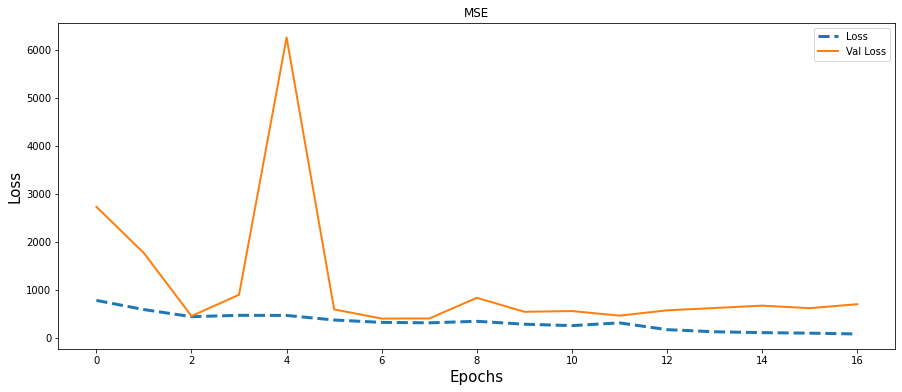

In [5]:
model = load_model('/content/drive/MyDrive/regression_xception_best_weights.h5')

plt.figure(figsize = (15, 6))
plt.plot(history.history['loss'], lw = 3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('MSE')
plt.legend();

In [6]:
val_images.reset()
predicted_intensity = np.squeeze(model.predict(val_images))
#predicted_intensity = np.round(predicted_intensity/5, 0)*5
true_intensity = val_images.labels

rmse = np.sqrt(model.evaluate(val_images, verbose = 0))
print("Validation RMSE: {:.5f}".format(rmse))

print('Standard deviation in predicted validation intensities:', np.std(predicted_intensity))
mse = mean_squared_error(true_intensity, predicted_intensity)
print('Validation MSE: {:.2f}'.format(mse))
mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Validation MAE: {:.2f}'.format(mae))

169/169 [==============================] - 4s 17ms/step
Validation RMSE: 19.94184
Standard deviation in predicted validation intensities: 16.794287
Validation MSE: 397.68
Validation MAE: 15.13


**Inception**

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
InceptionV3_model = InceptionV3(input_shape = (310, 310, 3), weights = 'imagenet', include_top = False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True

InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation = 'relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(1, activation = 'linear')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs = InceptionV3_model.input, outputs = InceptionV3_x)

InceptionV3_x_final_model.compile(optimizer = 'adam', loss = 'mse')

# Create a checkpoint to save best weights
checkpoint = ModelCheckpoint('/content/drive/MyDrive/regression_inception_best_weights.h5', monitor='val_loss', save_best_only=True, mode='min')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

history = InceptionV3_x_final_model.fit(train_images, epochs = 40, validation_data = val_images, verbose = 1, callbacks =[checkpoint, early_stopping, lr_scheduler])

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/40
723/723 [==============================] - 105s 125ms/step - loss: 862.0137 - val_loss: 863.5989 - lr: 0.0010
Epoch 2/40
723/723 [==============================] - 79s 109ms/step - loss: 410.5815 - val_loss: 510.7779 - lr: 0.0010
Epoch 3/40
723/723 [==============================] - 76s 106ms/step - loss: 324.9175 - val_loss: 519.0243 - lr: 0.0010
Epoch 4/40
723/723 [==============================] - 75s 104ms/step - loss: 321.1862 - val_loss: 468.1111 - lr: 0.0010
Epoch 5/40
723/723 [==============================] - 83s 115ms/step - loss: 252.4731 - val_loss: 431.7422 - lr: 0.0010
Epoch 6/40
723/723 [==============================] - 76s 105ms/step - loss: 244.4406 - val_loss: 355.1955 - lr: 0.0010
Epoch 7/40
723/723 [==============================] - 74s 102ms/step - loss: 198.4170 - val_loss: 424.4731 - lr: 0.0010
Epoch 8/40
723/723 [==============================] - 67s 93ms/step - loss: 189.8340 - val_los

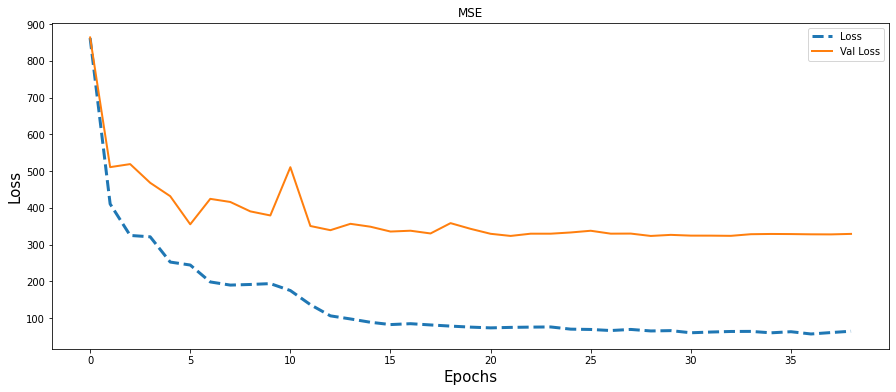

In [8]:
model = load_model('/content/drive/MyDrive/regression_inception_best_weights.h5')

plt.figure(figsize = (15, 6))
plt.plot(history.history['loss'], lw = 3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('MSE')
plt.legend();

In [9]:
val_images.reset()
predicted_intensity = np.squeeze(model.predict(val_images))
#predicted_intensity = np.round(predicted_intensity/5, 0)*5
true_intensity = val_images.labels

rmse = np.sqrt(model.evaluate(val_images, verbose = 0))
print("Validation RMSE: {:.5f}".format(rmse))

print('Standard deviation in predicted validation intensities:', np.std(predicted_intensity))
mse = mean_squared_error(true_intensity, predicted_intensity)
print('Validation MSE: {:.2f}'.format(mse))
mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Validation MAE: {:.2f}'.format(mae))

169/169 [==============================] - 5s 21ms/step
Validation RMSE: 17.98721
Standard deviation in predicted validation intensities: 15.729209
Validation MSE: 323.54
Validation MAE: 13.62


# **ResNet-50**

In [ ]:
# Load the ResNet50 model with pre-trained weights
model = ResNet50(weights='imagenet', include_top=False, input_shape=(310, 310, 3), classes=5)

# Freeze the layers of the model
for layer in model.layers:
    layer.trainable = False

# Add a new fully connected layer with the desired number of classes
x = Flatten()(model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Create a new model with the new output layer
resnet50_model = Model(inputs=model.input, outputs=predictions)

# Compile the model with a optimizer and loss function
resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('/content/drive/MyDrive/multiclass_resnet50_best_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
history = resnet50_model.fit(train_generator, epochs=30, validation_data=test_generator, callbacks=[checkpoint, lr_scheduler, early_stopping], verbose=1)

Epoch 1/30
723/723 [==============================] - 367s 483ms/step - loss: 6.1915 - accuracy: 0.2069 - val_loss: 1.6063 - val_accuracy: 0.2308 - lr: 0.0010
Epoch 2/30
723/723 [==============================] - 47s 65ms/step - loss: 1.6025 - accuracy: 0.2540 - val_loss: 1.5999 - val_accuracy: 0.2308 - lr: 0.0010
Epoch 3/30
723/723 [==============================] - 46s 64ms/step - loss: 1.5984 - accuracy: 0.2540 - val_loss: 1.5972 - val_accuracy: 0.2308 - lr: 0.0010
Epoch 4/30
723/723 [==============================] - 45s 62ms/step - loss: 1.5965 - accuracy: 0.2540 - val_loss: 1.5954 - val_accuracy: 0.2308 - lr: 0.0010
Epoch 5/30
723/723 [==============================] - 45s 62ms/step - loss: 1.6114 - accuracy: 0.2526 - val_loss: 1.5956 - val_accuracy: 0.2308 - lr: 0.0010
Epoch 6/30
723/723 [==============================] - 46s 64ms/step - loss: 1.5956 - accuracy: 0.2540 - val_loss: 1.5961 - val_accuracy: 0.2308 - lr: 0.0010
Epoch 7/30
723/723 [==============================] - 45

0.23076923191547394


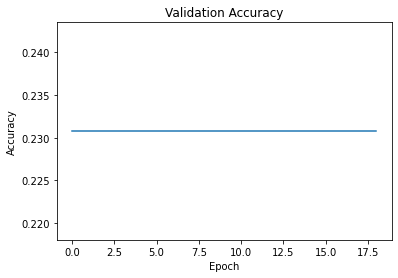

In [ ]:
# Extract the validation accuracy from the history object
test_acc = history.history['val_accuracy']
print(max(test_acc))

# Plot the validation accuracy over the course of training
plt.plot(test_acc)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# **Inceptionv3**

In [ ]:
# Load the InceptionV3 model with pre-trained weights
model = InceptionV3(input_shape = (310, 310, 3), weights = 'imagenet', include_top = False, classes=5)
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

InceptionV3_last_output = model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation = 'relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(5, activation = 'softmax')(InceptionV3_x)
inceptionv3_model = Model(inputs = model.input, outputs = InceptionV3_x)

# Compile the model with a optimizer and loss function
inceptionv3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('/content/drive/MyDrive/multiclass_inceptionv3_best_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

In [ ]:
history = inceptionv3_model.fit(train_generator, epochs = 30, validation_data =test_generator, callbacks = [checkpoint, lr_scheduler, early_stopping], verbose=1)

Epoch 1/30
723/723 [==============================] - 85s 101ms/step - loss: 5.5658 - accuracy: 0.2664 - val_loss: 1.5855 - val_accuracy: 0.2663 - lr: 0.0010
Epoch 2/30
723/723 [==============================] - 74s 103ms/step - loss: 1.5095 - accuracy: 0.3467 - val_loss: 2.4654 - val_accuracy: 0.2959 - lr: 0.0010
Epoch 3/30
723/723 [==============================] - 58s 81ms/step - loss: 1.4181 - accuracy: 0.3896 - val_loss: 2.3977 - val_accuracy: 0.2426 - lr: 0.0010
Epoch 4/30
723/723 [==============================] - 68s 94ms/step - loss: 1.3756 - accuracy: 0.4111 - val_loss: 1.9393 - val_accuracy: 0.3018 - lr: 0.0010
Epoch 5/30
723/723 [==============================] - 59s 82ms/step - loss: 1.3232 - accuracy: 0.4256 - val_loss: 2.2964 - val_accuracy: 0.2426 - lr: 0.0010
Epoch 6/30
723/723 [==============================] - 54s 74ms/step - loss: 1.2113 - accuracy: 0.4595 - val_loss: 2.3403 - val_accuracy: 0.2544 - lr: 0.0010
Epoch 7/30
723/723 [==============================] - 53

In [ ]:
# Extract the validation accuracy from the history object
test_acc = history.history['val_accuracy']
print(max(test_acc))

0.30177515745162964


# **Xception**

In [ ]:
xception_model = Xception(include_top = False, weights = "imagenet", input_shape = (310, 310, 3), classes=5)

x = Flatten()(xception_model.output)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(5, activation = 'softmax')(x)

xception_model = Model(inputs = xception_model.input, outputs = x)

# Compile the model with a optimizer and loss function
xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('/content/drive/MyDrive/multiclass_xception_best_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

In [ ]:
history = xception_model.fit(train_generator, epochs = 30, validation_data =test_generator, callbacks=[checkpoint, lr_scheduler, early_stopping], verbose=1)

Epoch 1/30
723/723 [==============================] - 107s 109ms/step - loss: 1.6942 - accuracy: 0.2138 - val_loss: 680.6533 - val_accuracy: 0.2308 - lr: 0.0010
Epoch 2/30
723/723 [==============================] - 68s 94ms/step - loss: 1.9393 - accuracy: 0.2270 - val_loss: 2.9398 - val_accuracy: 0.2249 - lr: 0.0010
Epoch 3/30
723/723 [==============================] - 70s 96ms/step - loss: 1.6413 - accuracy: 0.2824 - val_loss: 1.6097 - val_accuracy: 0.1716 - lr: 0.0010
Epoch 4/30
723/723 [==============================] - 76s 105ms/step - loss: 1.6137 - accuracy: 0.2775 - val_loss: 1.8972 - val_accuracy: 0.2959 - lr: 0.0010
Epoch 5/30
723/723 [==============================] - 70s 97ms/step - loss: 1.6179 - accuracy: 0.2789 - val_loss: 1.5936 - val_accuracy: 0.2840 - lr: 0.0010
Epoch 6/30
723/723 [==============================] - 67s 93ms/step - loss: 1.5997 - accuracy: 0.2740 - val_loss: 2.2517 - val_accuracy: 0.2959 - lr: 0.0010
Epoch 7/30
723/723 [==============================] -

In [ ]:
# Extract the validation accuracy from the history object
test_acc=history.history['val_accuracy']
print(max(test_acc))

0.3195266127586365


# **VGG-16**

In [ ]:
vgg16_model = VGG16(pooling = 'avg', weights = 'imagenet', include_top = False, input_shape=(310, 310, 3))

for layers in vgg16_model.layers:
    layers.trainable = False

last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(5, activation = 'softmax')(vgg_x)
vgg16_model = Model(vgg16_model.input, vgg_x)

# Compile the model with a optimizer and loss function
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/multiclass_vgg16_best_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

In [ ]:
history = vgg16_model.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[checkpoint, lr_scheduler, early_stopping], verbose=1)

Epoch 1/30
723/723 [==============================] - 53s 70ms/step - loss: 1.5949 - accuracy: 0.2824 - val_loss: 1.6651 - val_accuracy: 0.2426 - lr: 0.0010
Epoch 2/30
723/723 [==============================] - 44s 60ms/step - loss: 1.5353 - accuracy: 0.3024 - val_loss: 1.6495 - val_accuracy: 0.2485 - lr: 0.0010
Epoch 3/30
723/723 [==============================] - 42s 59ms/step - loss: 1.5039 - accuracy: 0.3100 - val_loss: 1.6153 - val_accuracy: 0.2722 - lr: 0.0010
Epoch 4/30
723/723 [==============================] - 43s 59ms/step - loss: 1.4747 - accuracy: 0.3426 - val_loss: 1.6637 - val_accuracy: 0.2544 - lr: 0.0010
Epoch 5/30
723/723 [==============================] - 46s 63ms/step - loss: 1.4489 - accuracy: 0.3606 - val_loss: 1.6492 - val_accuracy: 0.2781 - lr: 0.0010
Epoch 6/30
723/723 [==============================] - 43s 59ms/step - loss: 1.4339 - accuracy: 0.3626 - val_loss: 1.6764 - val_accuracy: 0.2544 - lr: 0.0010
Epoch 7/30
723/723 [==============================] - 45s 

In [ ]:
# Extract the validation accuracy from the history object
test_acc = history.history['val_accuracy']
print(max(test_acc))

0.2840236723423004


# **Ensembling**

In [ ]:
resnet_model = tf.keras.models.load_model('/content/drive/MyDrive/multiclass_resnet50_best_weights.h5')
xception_model = tf.keras.models.load_model('/content/drive/MyDrive/multiclass_xception_best_weights.h5')
proposed_model = tf.keras.models.load_model('/content/drive/MyDrive/multiclass_proposed_best_weights.h5')
inception_model = tf.keras.models.load_model('/content/drive/MyDrive/multiclass_inceptionv3_best_weights.h5')
#vgg16_model = tf.keras.models.load_model('/content/drive/MyDrive/multiclass_vgg16_best_weights.h5')

In [ ]:
seg_test_folders = '/content/drive/MyDrive/val'

In [ ]:
from collections import Counter
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

In [ ]:
import cv2
true_value = []
combined_model_pred = []
xception_pred = []
resnet_pred = []
proposed_pred = []
inception_pred = []
vgg16_pred = []
for folder in os.listdir(seg_test_folders):
    
    test_image_ids = os.listdir(os.path.join(seg_test_folders,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(seg_test_folders,folder,image_id)
        
        true_value.append(val_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(310,310))
        img_normalized = img/255

        resnet_image_prediction = np.argmax(resnet_model.predict(np.array([img_normalized])))
        resnet_pred.append(resnet_image_prediction)
        
        xception_image_prediction = np.argmax(xception_model.predict(np.array([img_normalized])))
        xception_pred.append(xception_image_prediction)
        
        inception_image_prediction = np.argmax(inception_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)
        '''
        vgg16_image_prediction = np.argmax(vgg16_model.predict(np.array([img_normalized])))
        vgg16_pred.append(vgg16_image_prediction)
        '''
        
        proposed_image_prediction = np.argmax(proposed_model.predict(np.array([img_normalized])))
        proposed_pred.append(proposed_image_prediction)
        
        #giving high priority if they all predict something different
        image_prediction = mode([resnet_image_prediction, proposed_image_prediction, xception_image_prediction, inception_image_prediction])                                  
        combined_model_pred.append(image_prediction)

In [ ]:
classes = val_generator.class_indices.keys()
TP_count = [true_value[i] == combined_model_pred[i] for i in range(len(true_value))]
model_accuracy = np.sum(TP_count)/len(TP_count)
print('Model Accuracy', model_accuracy)

In [ ]:
import itertools
def clf_report(true_value, model_pred):
    classes = val_generator.class_indices.keys()
    classes = val_generator.class_indices.keys()
    TP_count = [true_value[i] == combined_model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    '''
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    print(classification_report(true_value, model_pred, target_names = list(classes)))
    '''

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
combined_model_pred = [c[0] for c in combined_model_pred]
clf_report(true_value, combined_model_pred)

Model Accuracy 0.273972602739726


**Testing**

In [ ]:
model.load_weights('/content/drive/MyDrive/multiclass_proposed_best_weights.h5')

In [ ]:
# Make predictions on the validation data
predictions = model.predict(val_generator, steps=len(val_generator))

# Convert the predictions to a class label
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
confusion_matrix = confusion_matrix(val_generator.classes, predicted_classes)
print(confusion_matrix)

In [ ]:
import matplotlib.pyplot as plt

# Normalize the confusion matrix
normalized_confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Annotate the cells with the values
for i in range(num_classes):
    for j in range(num_classes):
        text = plt.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="w")

plt.show()

In [ ]:
test_dir = '/content/drive/MyDrive/multiclass_2022'

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (310, 310), batch_size = 1, class_mode = 'categorical', shuffle = False)

Found 41 images belonging to 5 classes.


In [ ]:
predictions = model.predict_geenrator(test_generator, steps = len(test_generator))

AttributeError: ignored